El presente cuaderno tiene como objetivo ser un resumen de la problematica asociada a la implementación del Tren de potencia del Eolian Áuriga, de su implementación y modelamiento.

Los resutados de simulación no son presentados aquí

# Configuración del Inversor y análisis de datos obtenidos
El siguiente cuaderno tiene como objetivo permitir el despliegue, y análisis de datos obtenidos del Inversor Sevcon cuando controla el motor BLDC.
Los datos obtenidos y la configuración del Inversor son mediante CANopen (y DVT). Se presenta tambien el registro de configuración del inversor y los parámetros establecidos.

## Contexto
La implementación del Sistema de Tracción del Eolian 6 supone la utilización de dos Inversores Sevcon gen 4 size 4 con 96V nominal con 150Nm de torque max, y dos motores BLDC de 96 V nominales, 2kw de potencia nominal.
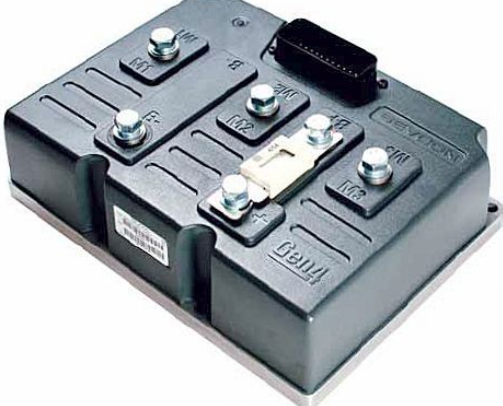

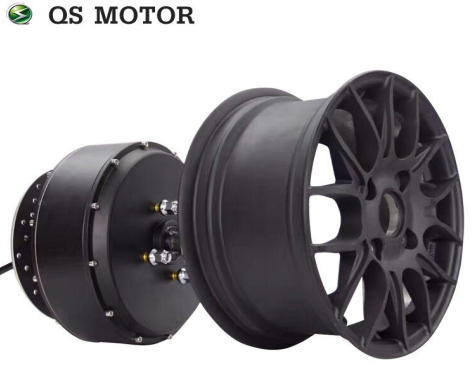

El motor tiene 16 pares de polos, es de flujo radial y sin polos salientes.

Para la puesta en marcha, se presenta un diagrama de bloquees detallado basado en las indicaciones del manual del sevcon y otras fuentes
https://www.thunderstruck-ev.com/images/Gen4%20Product%20Manual%20V3%204.pdf

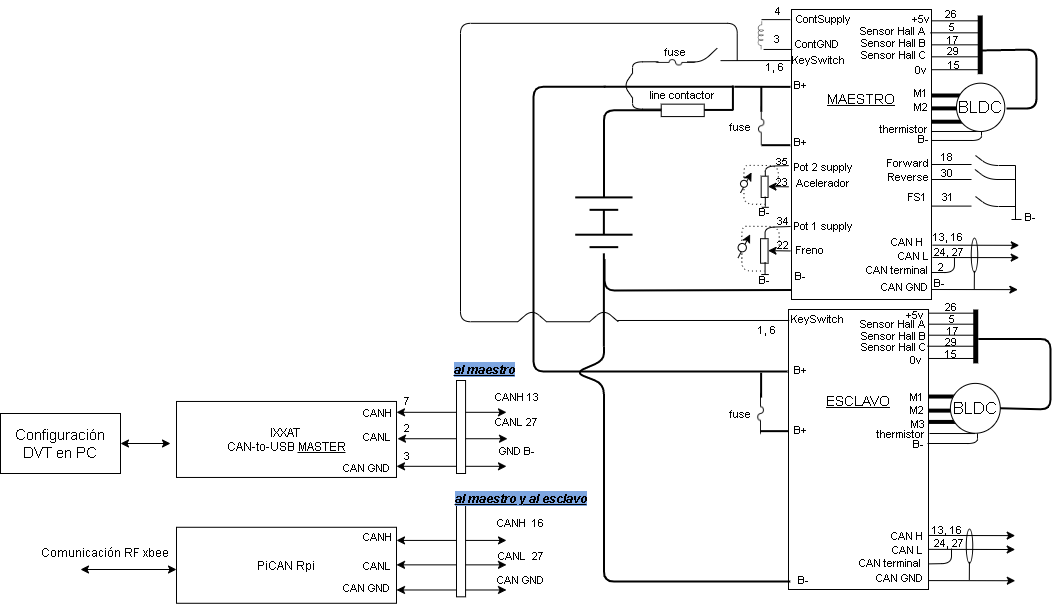

Luego, como sera utilizado mas adelante, aqui se estipula que el calculo de eficiencia utilizando las lecturas del sevcon es $\eta = \frac{T_{em} \cdot w_{em}}{U_{batería} \cdot I_{batería}}$

https://aaltodoc.aalto.fi/handle/123456789/25108 

Como objetivos generales estan:

*   La implementación del Sistema de tracción completo para su ser incoroporación en el automóvil solar.
*   Establecer la comunicación en CANopen para monitoriar el sistema externamente.
*   Implementar un modelo que permita analizar cuantitativamente los resultados obtenidos en la implementación física.

De esta manera los objetivos específicos son:
* Establecer conexiones del inversor
* Configurar el modo de funcionamiento de inversores como demanda de torque (corriente) del motor.
* Configuración Meastro-Esclavo en DVT con conexión CANopen(2 inversores, 2 motores).
* Configurar los mensajes desde y hacia el inversor mediante CANopen. Comunicación con Rpi.
* Establer un modelo e identificar/sintonizar los parámetros para su puesta en marcha y validación.

## Estado del Arte 
Para el modelamiento del sistema de tracción es necesario modelar el control de corriente en lazo cerrado de un motor de imanes permanentes PMSM.
Por otro lado, un modelo eléctrico del BLDC esta definido en equilibrio de corrientes como
\begin{equation}
\begin{pmatrix}
V_{an} \\
V_{bn} \\
V_{cn} 
\end{pmatrix}=
\begin{pmatrix}
L_{s}-M & 0 & 0\\
0 & L_{s}-M & 0\\
0 & 0 & L_{s}-M
\end{pmatrix}
\begin{pmatrix}
\frac{di_{a}}{dt} \\
\frac{di_{b}}{dt} \\
\frac{di_{c}}{dt} 
\end{pmatrix}
+
\begin{pmatrix}
R_{s} & 0 & 0\\
0 & R_{s} & 0\\
0 & 0 & R_{s}
\end{pmatrix}
\begin{pmatrix}
i_{a} \\
i_{b} \\
i_{c}
\end{pmatrix}
+
\begin{pmatrix}
E_{a} \\
E_{b} \\
E_{c}
\end{pmatrix}
\end{equation}
La ecuación mecánica se define como 
\begin{equation}
    J\frac{d w_{m}}{dt}+Bw_{m}(t) = T_{e}(t) - M_{m}(t)
\end{equation}
Despues, Un BLDC se puede modelar como un PMSM, y es posible modelarlo sabiendo que de las tres fases que alimentan al motor, 2 siempre están activas conduciendo corriente (two level three phase converter). 
\begin{equation}
    i_{a} = -i_{b} = i
\end{equation}

\begin{equation}
    \frac{di_{a}}{dt}=-\frac{di_{b}}{dt}=\frac{di}{dt}
\end{equation}
Luego, considerando el voltaje de linea $V_{ab} = V_{an} - V_{bn}$, se tiene que
\begin{equation}
    V_{ab}=2R_{s}i + 2(L_{s}-M)\frac{di}{dt}+(E_{a}-E_{b})
\end{equation}
Considerando que en el transiente no existe conmutación de la fuerza electromotriz, se tiene que la parte estacionaria de $E_{a}$ y $E_{b}$ es igual en amplitud, pero en sentidos opuestos.
\begin{equation}
    V_{ab}=2R_{s}i + 2(L_{s}-M)\frac{di}{dt}+K_{e}w_{m}
\end{equation}
Reescribiendo la formula con $R =2R_{s}$ y $L=2(L-M)$. La corriente es proporcional al torque $T_{e}(t) = K_{t}i(t)$ entonces, se tiene que la dinámica del BLDC es tal que.
\begin{equation}
    V_{ab}=Ri + L\frac{di}{dt}+K_{e}w_{m}
\end{equation}

\begin{equation}
    J\frac{d w_{m}}{dt}+Bw_{m} = K_{t}i - M_{m}
\end{equation}



L, es la inductancia en $\mu H$,R la resistencia de fase, Kt es la cte de torque en $\frac{Nm}{A}$ 

Por otro lado, para el modelamiento del BLDC mediant PMSM en transformada de Park, existe un enfoque mas real del funcionamiento del Sevcon, donde las demandas de torque son transformadas en demandas de corrientes de cuadratura que entran a un lazo cerraddo de control de corriente.



\begin{equation}
    V_{q}=Ri + L\frac{di_{q}}{dt}+w_{m}(L_{d}I_{d}+K_{e})
\end{equation}

\begin{equation}
    V_{d}=Ri + L\frac{di_{d}}{dt}-L_{q}w_{m}i_{q}
\end{equation}

\begin{equation}
    J\frac{d w_{m}}{dt}+Bw_{m} = \frac{3}{2}PK_{e}i_{q} - M_{m}
\end{equation}


En ambos modelos la potencia de salida del motor queda definida como


\begin{equation}
   P_{em} = T_{em}\cdot w_{em}
\end{equation}
con $w_{m} = \frac{P}{2}w_{em}$


$P$ es el numero de polos, $K_{e}$ es la constante EMF en $\frac{V}{rad/s}$

El sistema de control de corriente(torque) o velocidad(frecuencia) utliza en lazos con controles PI.
Se presenta el esquematico básico asociado el control









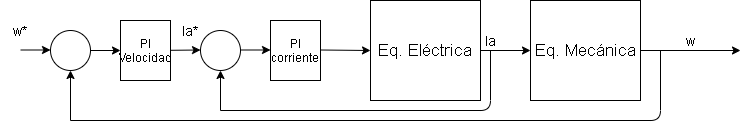

En particular, para este modelo y el anterior el diseño de las maquinas de iman permanten esta asociado a un flujo constante en el rotor que interactua con las corrientes de armadura en el estator del motor. De esta manera, el control se hace controlando la corriente de la armadura y de manera electrónica utilizando un puente completo de trasistores mosfet que realizan la conmutación conociendo la posición del rotor con sensores hall.

Es importante la configuración de los sensores hall ya que esta asociado a las demandas de corrientes que se haran en cada conmutación.

Para mas información asociada a la configuración de los sensores hall. Esos son configurados como señales UVW desfasadas en ese orden en 120º eléctricos.

https://www.e-kart.fr/images/stories/technique/SEVCON/sevcon-app-note-pmac.pdf

# Configuración del Inversor

A continuación se presenta un breve resumen para la configuración del objeto de diccionario y el objeto de diccionario establecido.

La configuración completa es epecificada en la siguiente hoja de calculo

https://docs.google.com/spreadsheets/d/1hp0NTYhOq3u26fyoya1HHdCFf30lwmXK8TWeJC9LR1s/edit?usp=sharing

La configuración del Inversor se realiza mediante CANopen utilizando el software DVT proporcionado por Sevcon.

En la ventana inicial se establece el baudrate en 1Mhz

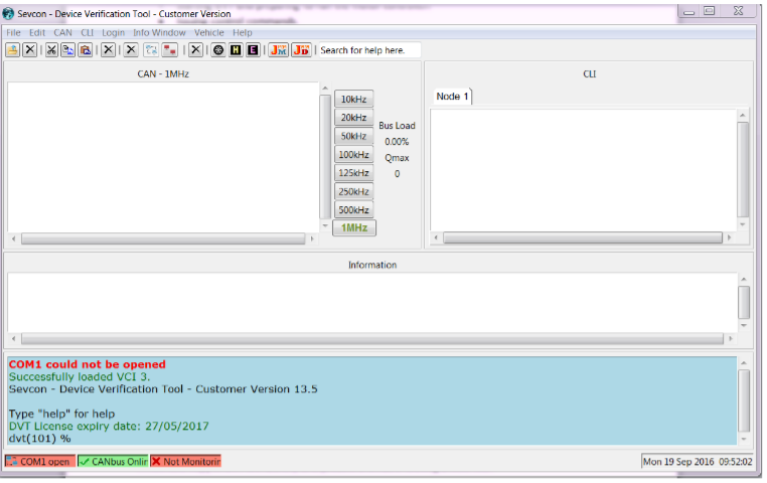

Utlizando el helper disponible en la ventana inicial es posible configurar los principales mapeados que permiten accionar el motor.
Algunos de estos parámetros son el estado del nodo CANopen en operacional(listo para conducción) o en pre operación(para configuración).
Uno de los parámetros a establecer mas importantes son el offset del motor para la medición de la posición del rotor utilizando los sensores hall. Aqui, para un BLDC estableciendo bien las fases y los sensores hall en los pines presentados en código de colores, dejando el offset en cero permite mejorar las lecturas de velocidad y eficiencia que serán mostradas mas adelante.

Es necesaria la configuración del porcentaje maximo de torque demandado a partir del valor peak, se deben definir las ganancias en de corriente y velocidad.
El modo de conduccion es en control del torque por lo que se deja la velocidad fijada al maximo establecido y utlizando las ganancias de velocidad(speed limit)De igual forma, deben especificarse los valores nominales del motor como la constante de voltaje y el número de polos.


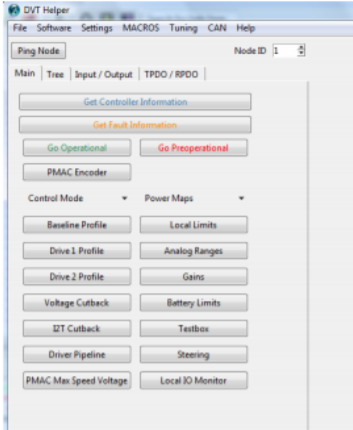

Configurando los mensajes de salida del inversor, es posible verlos en la interfaz del DVT para grabarlos.
Es posible visualizar las corrientes de cuadratura, la demanada de torque(torqu actual y torque demandado), la temperatura, etc.

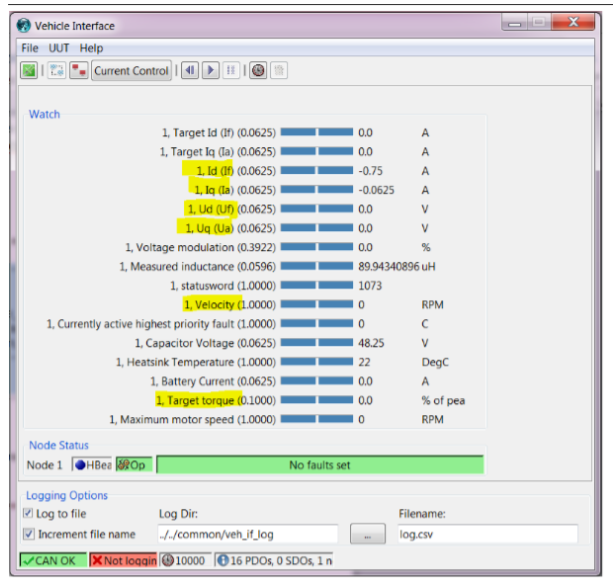

## Se presentan los parámetros especificados en la configuración de inversor

4.-MOTOR PARAMETERS PMAC

	
Parametros Motor PMAC=PMSM

*	***Maximum Stator Current (Is_max): 230 A(RMS) ***
		- Corriente maxima del estator, usar como referencia el maximo del inversor 300A, la suma de las corrientes en las fases (la velocidad maxima se desconoce) y puede establecer a partir del torque peak configurado
		
*	***Minimum Magnetising Current (Im_min): -80 A(RMS)*** 
	
	- Corriente minima utilizada en el debilitamiento de campo (field weakening plz) .d-axis or magnetizing; current will be present in the motor so that the vehicle will respond immediately to a torque demand. To save energythe magnetizing current is removed if the vehicle is stationary and no torque has been demanded after a set period

*	***Number of Pole Pairs (np): 16.0***
	
	- Numero de par de polos

*	***Rated Stator Current: 70.0 A(RMS) ***

		- Valor nominal de la corriente del estadot y definida por los datos de plaa
*	***Stator Leakage Inductance (Lls): 300 uH***

		- Inductancia de estator
*	***Nominal battery voltage: 105.0 V***
		- Voltaje nominal de la bateria
*	***Current control proportional gain (Kp): 5.6***

		- Ganancia proporcional control PI corriente Idq
*	***Current control integral gain: 0.004***

		- Ganancia proporcional control PI corriente Idq
*	***Torque control integral gain: 0.850006103515625***

		- Ganancia integral control PI corriente Idq
*	***Voltage Constant (Ke): 0.022 V/rads*** 
		- Constante de flujo magnetico rotor en Wb o V/rad/s
*	Frequency control Kp: 0.00048828

		- Frecuencia de ganacias Kp (valor predeterminado)
*	***Frequency control Ki: 0.00149536***
		- Frecuencia de ganacias Ki (valor predeterminado)
*	***Max drive mod index: 100 %***
		- Porcentaje de prioridad en directa o forward
*	***Max brake mod index: 100.0 % ***
		- Porcentaje de prioridad en footbraking
*	***Voltage Control Kp: 0.0***

*	***Voltage Control Ki: 0.0***

*	***D-axis current controller proportional = 0.0***
	- No se utiliza ganancias para debilitamiento de campo, se replican las del control Iq kp y ki
*	***D-axis current Controller Integral Gain = 0.0***
	- No se utiliza ganancias para debilitamiento de campo, se replican las del control Iq kp y ki
*	***Percentage minimum allowed saturation of Ls: 50 %***
 - porcentaje de saturacion de la inductancia


BASELINE PROFILE 

* ***Torque applied during drive:	100	%***

* ***Torque applied during a direction change:	50	%***

* ***Torque applied when neutral braking:	10	%***

* ***Torque applied when footbraking:	100%***

* ***Maximum Speed in forward direction:	850	rpm***

* ***Maxmium Speed in reverse direction:	850	rpm***

* ***Ramp up rate during drive:	900%/s***

* ***Ramp up rate during direction change braking:	200	%/s***

* ***Ramp up rate during neutral braking:	200	%/s***

* ***Ramp up rate durinng footbraking:	900%/s***

* ***Ramp down rate during drive:	900	%/s***

* ***Ramp down rate during direction change braking:	200	%/s***

* ***Ramp down rate during neutral braking:	200	%/s***

* ***Ramp down rate during footbraking:	900	%/s***

* ***Speed limit ramp up rate when in torque mode:	900	rpm/s***

* ***Speed limit ramp down rate when in torque:	900	rpm/s***

5.-LOCAL LIMITS

* ***Maximum Torque:	100% del peak***
* ***Torque slope:	900	% rated/s***
* ***Current limit:	200	A(rms)***
* ***Peak Torque:	120	Nm***
* ***Maximum Motor Speed:	850	RPM***
* ***Maximun acceleration rate:	900	rpm/s***
* ***Motor over speed protection:	900	RPM***




6.- BASE LINE

* ***Torque applied during drive:	100	%***
* ***Torque applied during a direction change:	50	%***
* ***Torque applied when neutral braking:	10	%***
* ***Torque applied when footbraking:	100	%***
* ***Maximum Speed in forward direction:	850	rpm***
* ***Maxmium Speed in reverse direction:	850 rpm***
* ***Ramp up rate during drive:	900	%/s***
* ***Ramp up rate during direction change braking:	200	%/s***
* ***Ramp up rate during neutral braking:	200	%/s***
* ***Ramp up rate durinng footbraking:	900	%/s***
* ***Ramp down rate during drive:	900	%/s***
* ***Ramp down rate during direction change braking:	200	%/s***
* ***Ramp down rate during neutral braking:	200	%/s***
* ***Ramp down rate during footbraking:	900	%/s***
* ***Speed limit ramp up rate when in torque mode:	900	rpm/s***
* ***Speed limit ramp down rate when in torque: 900	rpm/s***

SPEED CURRENT GAINS



* ***Speed control porportional gain (Kp):	0.8***
* ***Speed control integral gain (Ki):	0,00497***
* ***Low Speed proportional gain:	0***
* ***Rollback integral Gain:	0***
* ***Low speed integral gain:	0***
* ***dw/dt:	0***
* ***Integral initialization factor:	0***
* ***Speed calculation filter pole:	0***
* ***Pre-limit speed:	0***
* ***Maximum speed limit ramp down rate:	1000***

CURRENT GAINS

* ***Current control porportional gain (Kp):	5,398***
* ***Current control integral gain (Ki):	0,00497***
* ***D-axis Kp:	0***
* ***D-axis Ki:	0***

BATTERY SET UP Batery Aplication	track app

* ***Batt Nominal Voltage:	105	V***
* ***Batt Overvolt Protection  -  Over voltage star cutback:	125	V***
* ***Batt Overvolt Protection  -  Over voltage limit:	130	V***
* ***Batt Undervolt Protection  -  Under voltage star cutback limit:	65	V***
* ***Batt Undervolt Protection - Under voltage limit:	60	V***

Voltage torque-Cutback Map(motor )cutback	Voltage	Voltage Cutback Gain
 - V ; Cutback_gain
 - 0 ; 0
 - 60 ; 0
 - 60 ;	0
 - 60	; 0
 - 60	; 0
 - 70	; 1
 - 120	; 1
 - 126	; 0
 - 126	; 0

Esto valores entregados solo corresponden a una parte de la configuración total del inversor como lo son las entradas digitales y analógicas.

9.-TORQUE MAP

Se presenta el mapa de potencia que establece el torque maximo a cada velocidad
El maximo torque aplicaqdo es el peak torque hasta la velcidad maxima establecida en 670RPM. La velocidad sin carga del motor es 950RPM, pero debido a temas de estabilidad en la base de pruebas a lo maximo que se a podido llegar es 720RPM


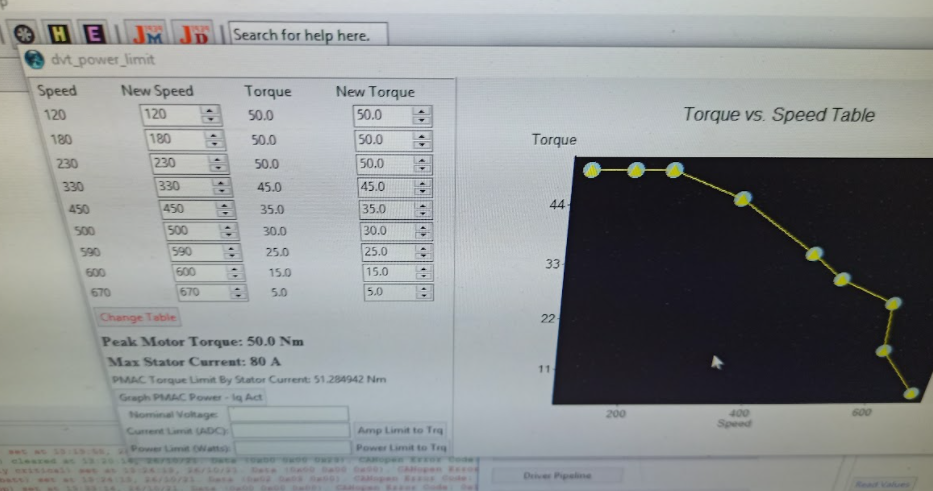

Cabe recalcar que es posible tomar un porcentaje del torque aplicado en el mapa a aprtir del baseline profile.

 	Power Limit Map - Pt 1 Max Torque: 140 Nm 
 	Power Limit Map - Pt 1 Speed: 10 RPM 
 	Power Limit Map - Pt 2 Max Torque: 140 Nm 
 	Power Limit Map - Pt 2 Speed: 200 RPM 
 	Power Limit Map - Pt 3 Max Torque: 140 Nm 
 	Power Limit Map - Pt 3 Speed: 267 RPM 
 	Power Limit Map - Pt 4 Max Torque: 121 Nm 
 	Power Limit Map - Pt 4 Speed: 310 RPM 
	Power Limit Map - Pt 5 Max Torque: 83 Nm 
	Power Limit Map - Pt 5 Speed: 450 RPM 
 	Power Limit Map - Pt 6 Max Torque: 69 Nm 
 	Power Limit Map - Pt 6 Speed: 540 RPM 
	Power Limit Map - Pt 7 Max Torque: 56 Nm 
	Power Limit Map - Pt 7 Speed: 670 RPM 
	Power Limit Map - Pt 8 Max Torque: 47 Nm 
	Power Limit Map - Pt 8 Speed: 790 RPM 
	Power Limit Map - Pt 9 Max Torque: 44 Nm 
	Power Limit Map - Pt 9 Speed: 850 RPM 

10.- MOTOR 

	peak torque: 150 Nm
	Torque slope: 2000%rad/s
	Current limit 80 A(RMS)

11.- ENCODER

Angulo de offset(valor no real) 

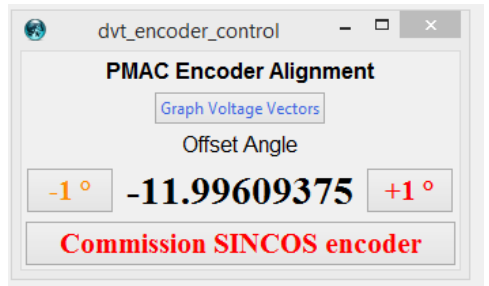

Una de las principlaes referencias que se tiene para el modelamiento es

https://www.researchgate.net/publication/292877983

# Despliegue y análisis de datos obtenidos por el Sevcon

Se presenta el codigo que permite las lecturas del cvs del DVT

Librerias importantes

In [ ]:
# Librerias importantes
import numpy as np
import matplotlib.pyplot as plt
import pandas 
import csv
from numpy import nan

Funciones importantes para la lectura de archivos obtenidos de DVT

In [ ]:
def rpm2rad(Rpm):
    """
    RPM a velocidad angular
    """
    w = (2 * np.pi * Rpm) / 60
    return w
def pot_out(Rpm, trq):
    """
    Funcion calculo de potenci de salida motor
    """
    Pot= rpm2rad(Rpm) * trq 
    return Pot
from scipy.signal import savgol_filter
def filtro_ruido(data):
    """
    Funcion filtro de ruido
    """
    flt = savgol_filter(data, 101, 2)
    return flt
def p_in(V_bat, I_bat):
    """
    Funcion calculo de potencia inversor-motor
    """ 
    Pin = (V_bat * I_bat)
    return Pin
def I_Mag(Iq, Id):
    """
    Funcion calculo de magnitud de corriente
    """
    return np.sqrt(Id**2 + Iq**2)
def pot_controler(Iq, Vq, Id, Vd):
    """
    Funcion calculo de potencia salida inversor-motor
    """ 
    pinc = 1.5 * ((Vq * Iq) + (Vd * Id))
    return pinc
def eff(Rpm, trq, V_bat, I_bat):
    """
    Funcion calculo de eficiencia sistema bateria-inversor-motor
    """ 
    pot = pot_out(Rpm, trq)
    pot[pot == 0] = 1e-16
    pin = p_in(V_bat, I_bat)
    pin[pin == 0] = 1
    for i in range(len(pin)):
        if pin[i] == 0:
            pin[i] = 1
            pot[i] = 1e-6
    D = pot / pin
    D[D > 0.99999999999999] = 1
    D[D < 0] = 0
    return D

In [ ]:
def lectura_variables_modelo(file):
    """
    Funcion de lectura DVT de variables TPDO en formato csv
    para modelo del proceso
    """
    df = pandas.read_csv(file, sep=',', low_memory=False)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.loc[:, ~df.columns.str.contains('0x0081_Low_batt')]
    df = df.loc[:, ~df.columns.str.contains('CONTROLLER_CONFIG')]
    df = df.loc[:, ~df.columns.str.contains('Time')]
    #
    # df = df.dropna()
    df['1. Iq A (0.0625)'] = df['1. Iq A (0.0625)'].astype(float) #1
    df['1. Id A (0.0625)'] = df['1. Id A (0.0625)'].astype(float) #2  
    df['1. Velocity RPM (1)'] = df['1. Velocity RPM (1)'].astype(float) #2
    df['1. Current A(RMS) (1)'] = df['1. Current A(RMS) (1)'].astype(float) #2
    df['1. Torque demand value Nm (0.0625)'] = df['1. Torque demand value Nm (0.0625)'].astype(float) #2
    df['1. Torque actual value Nm (0.0625)'] = df['1. Torque actual value Nm (0.0625)'].astype(float) #2
    # df['1. Target Iq A (0.0625)']  = df['1. Target Iq A (0.0625)'].astype(float)
    # df['1. Target Id A (0.0625)']  = df['1. Target Id A (0.0625)'].astype(float)
    # tgt_Iq = df['1. Target Iq A (0.0625)'] #1
    # tgt_Id = df['1. Target Id A (0.0625)'] #2
    iq = df['1. Iq A (0.0625)'] #3
    id = df['1. Id A (0.0625)'] #4
    Uq = df['1. Uq V (0.0625)'] #5
    Ud = df['1. Ud V (0.0625)'] #6
    Ibat = df['1. Battery Current A (0.0625)'] #7
    Vbat = df['1. Battery Voltage V (0.0625)'] #8
    Rpm = df['1. Velocity RPM (1)']  #9
    trq_dmnd = df['1. Torque demand value Nm (0.0625)'] #10
    trq_actval = df['1. Torque actual value Nm (0.0625)'] #11
    throttle = df['1. Throttle Input Voltage V (0.00390625)'] #12
    heat = df['1. Heatsink Temperature DegC (1)'] #13
    stator_I1 = df['1. Current A(RMS) (1)'] #13
    #
    # df['2. Iq A (0.0625)'] = df['2. Iq A (0.0625)'].astype(float)
    # df['2. Id A (0.0625)'] = df['2. Id A (0.0625)'].astype(float)
    # df['2. Current A(RMS) (1)'] = df['2. Current A(RMS) (1)'].astype(float) #2
    # tgt_Iq2 = df['2. Target Iq A (0.0625)']
    # tgt_Id2 = df['2. Target Id A (0.0625)']
    # iq2 = df['2. Iq A (0.0625)']
    # id2 = df['2. Id A (0.0625)']
    # Uq2 = df['2. Uq V (0.0625)']
    # Ud2 = df['2. Ud V (0.0625)']
    # Ibat2 = df['2. Battery Current A (0.0625)']
    # Vbat2 = df['2. Battery Voltage V (0.0625)']
    # Rpm2 = df['2. Velocity RPM (1)']  
    # trq_dmnd2 = df['2. Torque demand value Nm (0.0625)']
    # trq_actval2 = df['2. Torque actual value Nm (0.0625)']
    # throttle2 = df['2. Throttle Input Voltage V (0.00390625)']
    # heat2 = df['2. Heatsink Temperature DegC (1)']
    # stator_I2 = df['2. Current A(RMS) (1)'] #13
    #
    # dat = np.asarray([tgt_Iq, tgt_Id, iq, id, Uq, Ud, Ibat, Vbat, Rpm,
    #        trq_dmnd, trq_actval, throttle, heat, stator_I1])
    dat = np.asarray([iq, id, Uq, Ud, Ibat, Vbat, Rpm,
           trq_dmnd, trq_actval, throttle, heat, stator_I1])
    #        [tgt_Iq2, tgt_Id2, iq2, id2, Uq2, Ud2, Ibat2, Vbat2, Rpm2, tgt_trq2,
    #        trq_dmnd2, trq_actval2, throttle2, heat2, stator_I2])
    #
    # dat = np.asarray(Rpm)
    dat[np.isnan(dat)] = 0
    # dat = np.asarray([Rpm,  trq_dmnd, trq_actval,  heat,Rpm2, trq_dmnd2, trq_actval2, heat2])
    # np.savetxt('data.csv', dat)
    return dat.astype(float)

def plot_modelo(file):
    """
    Funcion de lectura DVT de paramtros de configuracion entre dos archivos
    .dfc en csv o ddde la lectura de TPDO
    """
    d = lectura_variables_modelo(file)
    # Master
    # tgt_Iq1 = d[0, :len(d) - 500] #1
    # tgt_Id1 = d[1, :len(d) - 500] #2
    iq1 = d[0, :len(d)] #3
    id1 = d[1, :len(d)] #4
    Uq1 = d[2, :len(d)] #5
    Ud1 = d[3, :len(d)] #6
    Ibat1 = d[4, :len(d)] #7
    Vbat1 = d[5, :len(d)] #8
    Rpm1 = -d[6, :len(d)]  #9
    trq_dmnd1 = d[7, :len(d)] #10
    trq_actval1 = d[8, :len(d)] #11
    throttle1 = d[9, :len(d)] #12
    heat1 = d[10, :len(d)] #13
    stator_I1 = d[11, :len(d)] 
    # Slave
    # tgt_Iq2 = d[14, :len(d) - 500] #1
    # tgt_Id2 = d[15, :len(d) - 500] #2
    # iq2 = d[16, :len(d) - 500] #3
    # id2 = d[17, :len(d) - 500] #4
    # Uq2 = d[18, :len(d) - 500] #5
    # Ud2 = d[19, :len(d) - 500] #6
    # Ibat2 = d[20, :len(d) - 500] #7
    # Vbat2 = d[21, :len(d) - 500] #8
    # Rpm2 = d[22, :len(d) - 500]  #9
    # trq_dmnd2 = d[23, :len(d) - 500] #10
    # trq_actval2 = d[24, :len(d) - 500] #11
    # throttle2 = d[25, :len(d) - 500] #12
    # heat2 = d[26, :len(d) - 500] #13
    # stator_I2 = d[27, :len(d) - 500] 
    # numpy.savetxt("data3.csv", a, 
    #           delimiter = ",") 

    # Torque en Master-Slave
    plt.figure(0)
    plt.plot(trq_actval1, color='red', linewidth=2, linestyle='-',
             label='torque electro mecanico Master')
    plt.plot(trq_dmnd1, color='blue', linewidth=2, linestyle='-',
             label='torque demandado Master')
    # plt.plot(trq_actval2, color='green', linewidth=2, linestyle='-',
    #          label='torque electro mecanico Slave')
    # plt.plot(trq_dmnd2, color='yellow', linewidth=2, linestyle='-',
    #          label='torque demandado Slave')
    plt.xlabel('segundos')
    plt.ylabel('Nm')
    plt.title('torque actual y demanda en Master-Slave')
    plt.legend(loc="best")    
    plt.grid()
    # plt.savefig("torque.png")
    plt.show()
    # RPM
    plt.figure(1)
    plt.plot(Rpm1, color='red', linewidth=2, linestyle='-',
             label='Rpm mecanicas Master')
    # plt.plot(Rpm2, color='blue', linewidth=2, linestyle='-', 
    #          label='Rpm mecanicas Slave')
    plt.xlabel('segundos')
    plt.ylabel('RPM')
    plt.title('velocidad')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("rpm.png")
    plt.show()
    # Mapa de potencia en Master-Slave
    plt.figure(2)
    plt.plot(Rpm1, trq_actval1, color='red', linewidth=2, linestyle='-',
             label='Torque vs RPM Master')
    # plt.plot(Rpm2, trq_actval2, color='blue', linewidth=2, linestyle='-*',
    #          label='Torque vs RPM Slave')
    plt.xlabel('RPM')
    plt.ylabel('Nm')
    plt.title('Mapa potenca')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("abc.png")
    plt.show()
    # Corriente Iq
    plt.figure(3)
    plt.plot(iq1, color='red', linewidth=2, linestyle='-', label='Iq A Master')
    # plt.plot(tgt_Iq1, color='blue', linewidth=2, linestyle='-', 
    #          label=' Target Iq A Master')
    plt.xlabel('segundos')
    plt.ylabel('A')
    plt.title('Iq Master')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("pote.png")
    plt.show()
    #Corriente Id
    # Corriente Id
    plt.figure(5)
    plt.plot(id1, color='red', linewidth=2, linestyle='-', label='Id A Master')
    # plt.plot(tgt_Id1, color='blue', linewidth=2, linestyle='-',
    #          label=' Target Id A Master')
    plt.xlabel('segundos')
    plt.ylabel('A')
    plt.title('Iq Master')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("pote.png")
    plt.show()
    # Corriente Id
    # Uq
    plt.figure(7)
    plt.plot(Uq1, color='red', linewidth=2, linestyle='-',
             label='Uq V Master')
    # plt.plot(Uq2, color='blue', linewidth=2, linestyle='-',
    #          label='Uq V Slave')
    plt.xlabel('segundos')
    plt.ylabel('A')
    plt.title('Uq Master-Slave')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("pote.png")
    plt.show()
    # Ud
    plt.figure(8)
    plt.plot(Ud1, color='red', linewidth=2, linestyle='-',
             label='Ud V Master')
    # plt.plot(Ud2, color='blue', linewidth=2, linestyle='-',
    #          label='Ud V Slave')
    plt.xlabel('segundos')
    plt.ylabel('A')
    plt.title('Ud Master-Slave')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("pote.png")
    plt.show()
    # Voltaje bat
    plt.figure(9)
    plt.plot(Vbat1, color='red', linewidth=2, linestyle='-',
             label='Vbat V Master')
    # plt.plot(Vbat2, color='blue', linewidth=2, linestyle='-',
    #          label='Vbat V Slave')
    plt.xlabel('segundos')
    plt.ylabel('V')
    plt.title('Voltaje batería Master-Slave')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("efi.png")
    plt.show()
    # Ibat
    plt.figure(10)
    plt.plot(Ibat1, color='red', linewidth=2, linestyle='-', 
             label='A Master')
    # plt.plot(Ibat2, color='blue', linewidth=2, linestyle='-',
            #  label='A Slave')
    plt.xlabel('segundos')
    plt.ylabel('A')
    plt.title('Corriente batería Master- Slave')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("efi.png")
    plt.show()
    # V acelerador
    plt.figure(11)
    plt.plot(throttle1, color='red', linewidth=2, linestyle='-',
             label='acelerador V Master')
    # plt.plot(throttle2, color='blue', linewidth=2, linestyle='-',
            #  label='acelerador V Slave')
    plt.xlabel('segundos')
    plt.ylabel('V')
    plt.title('Voltaje acelerador Master- Slave')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("efi.png")
    plt.show()
    #
    plt.figure(12)
    plt.plot(heat1, color='red', linewidth=2, linestyle='-',
             label='Temperatura inversor C° Master')
    # plt.plot(heat2, color='blue', linewidth=2, linestyle='-', 
            #  label='Temperatura inversor C° Slave')
    plt.xlabel('segundos')
    plt.ylabel('C°')
    plt.title('Temperatura inversor C° Master- Slave')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("efi.png")
    plt.show()
    # Corriente estator
    plt.figure(13)
    plt.plot(stator_I1, color='red', linewidth=2, linestyle='-', 
             label='Corriente estator Arms Master')
    # plt.plot(stator_I2, color='blue', linewidth=2, linestyle='-',
            #  label='Corriente estator Arms Slave')
    plt.xlabel('segundos')
    plt.ylabel('C°')
    plt.title('Corriente estator A Master- Slave')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("efi.png")
    plt.show()
    # Magnitiud corriente
    plt.figure(14)
    plt.plot(I_Mag(iq1, id1), color='red', linewidth=2, 
             linestyle='-*', label='Corriente estator A Master')
    # plt.plot(I_Mag(iq2, id2), color='blue', linewidth=2,
            #  linestyle='-', label='Corriente estator A Slave')
    plt.xlabel('segundos')
    plt.ylabel('Arms')
    plt.title('Corriente estator A Master- Slave')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("efi.png")
    plt.show()
    # Potencia de entrada baterias
    plt.figure(15)
    plt.plot(p_in(Vbat1, Ibat1), color='red', linewidth=2,
             linestyle='-', label='Potencia Entrada W Master')
    # plt.plot(p_in(Vbat2, Ibat2), color='blue', linewidth=2,
            #  linestyle='-', label='Potencia Entrada W Slave')
    plt.xlabel('segundos')
    plt.ylabel('W')
    plt.title('Potencia Entrada Batería W Master-Slave')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("efi.png")
    plt.show()
    # Potencia de inversor-motor
    plt.figure(16)
    plt.plot(pot_controler(iq1, Uq1, id1, Ud1), color='red', linewidth=2, 
             linestyle='-', label='Potencia inversor-motor W Master')
    # plt.plot(pot_controler(iq2, Uq2, id2, Ud2), color='blue', linewidth=2,
            #  linestyle='-', label='Potencia inversor-motor  W Slave')
    plt.xlabel('segundos')
    plt.ylabel('W')
    plt.title('Potencia inversor-motor W Master- Slave')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("efi.png")
    plt.show()
    # Potencia de salida
    plt.figure(17)
    plt.plot(pot_out(Rpm1, trq_actval1), color='red', linewidth=2,
             linestyle='-*', label='Potencia Salida W Master')
    # plt.plot(pot_out(Rpm2, trq_actval2), color='blue', linewidth=2,
            #  linestyle='-', label='Potencia Salida W Slave')
    plt.xlabel('segundos')
    plt.ylabel('W')
    plt.title('Potencia Salida W Master- Slave')
    plt.legend(loc="best")
    plt.grid()
    # plt.savefig("efi.png")
    plt.show()
    
# def Ts(file):
#     """
#     Calculo Tiempo de muestreo condatos
#     """
#     df = pandas.read_csv(file, sep=',', low_memory=False)
#     df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#     df = df.loc[:, ~df.columns.str.contains('^CONTROLLER_CONFIG')]
#     df = df.dropna()
#     # time = df['Time (s)']
#     time = df['Time (s)']
#     tt = np.asarray(time).astype(float)
#     # t = tt[0]
#     # tf = t[len(t) -1]
#     # t0 = t[0]
#     # tiempo_range = tf - t0
#     # return tiempo_range / (len(t)-1)
#     return np.nan_to_num(tt)